In [1]:
# Fake News Prediction:
#   + About the Dataset:
#     1. id: unique id for a news article
#     2. title: the title of a news article
#     3. author: author of the news article
#     4. text: the text of the article; could be incomplete
#     5. label: a label that marks whether the news article is real or fake:
#       > 1: Fake news
#       > 0: real News

# Importing

In [14]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re #to perform regular expression operations
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
from nltk.util import ngrams
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV

In [15]:
#Printing the stopwords in English
import nltk
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Pre-Processing

In [16]:
#Loading the dataset
data = pd.read_csv('train.csv',index_col=0)

In [17]:
data.shape

(20800, 4)

In [18]:
data.head()

,title,author,text,label
id,,,,
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [19]:
#The number of missing values
data.isnull().sum()

title      558
author    1957
text        39
label        0
dtype: int64

In [20]:
#Replacing the missing values with an empty string
data=data.fillna('')

In [21]:
#Adding a description feature
data['content']=data['author']+''+data['title']

In [22]:
data['content']

id
0        Darrell LucusHouse Dem Aide: We Didn’t Even Se...
1        Daniel J. FlynnFLYNN: Hillary Clinton, Big Wom...
2        Consortiumnews.comWhy the Truth Might Get You ...
3        Jessica Purkiss15 Civilians Killed In Single U...
4        Howard PortnoyIranian woman jailed for fiction...
                               ...                        
20795    Jerome HudsonRapper T.I.: Trump a ’Poster Chil...
20796    Benjamin HoffmanN.F.L. Playoffs: Schedule, Mat...
20797    Michael J. de la Merced and Rachel AbramsMacy’...
20798    Alex AnsaryNATO, Russia To Hold Parallel Exerc...
20799               David SwansonWhat Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object

#Stemming

In [11]:
#This is the process of reducing a word to its root word

In [23]:
ps = PorterStemmer()

In [26]:
#This function performs stemming on the input text
def stemming(txt):
    stemmed_txt = re.sub('[^a-zA-Z]',' ',txt) #replace any non-alphabetic character in the text with a space
    stemmed_txt = stemmed_txt.lower()
    stemmed_txt = stemmed_txt.split() #split the text into individual words
    stemmed_txt = [ps.stem(word) for word in stemmed_txt if not word in stopwords.words('english')]
    stemmed_txt = ' '.join(stemmed_txt)
    return stemmed_txt

In [ ]:
data['stem_title']=data['title'].apply(stemming)

In [ ]:
data['stem_text']=data['text'].apply(stemming)

In [28]:
data['stem_content']=data['content'].apply(stemming)

In [17]:
data['stem_content'].head()

id
0    darrel lucushous dem aid even see comey letter...
1    daniel j flynnflynn hillari clinton big woman ...
2            consortiumnew comwhi truth might get fire
3    jessica purkiss civilian kill singl us airstri...
4    howard portnoyiranian woman jail fiction unpub...
Name: stem_content, dtype: object

In [29]:
#Separating the data and label
X = data['stem_content'].values
Y = data['label'].values

We are using the TfidfVectorizer class to convert a collection of text documents into a numerical matrix of TF-IDF features that will have one row per document in X and one column per unique word in the vocabulary learned by the vectorizer.
The values in the matrix represent the TF-IDF "Term Frequency-Inverse Document Frequency" score for each word in each document

In [30]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [20]:
type(X)

scipy.sparse._csr.csr_matrix

In [21]:
X.shape

(20800, 28419)

In [22]:
Y.shape

(20800,)

# Visualization

In [23]:
#We use the Word Cloud to see the most common key words in news titles

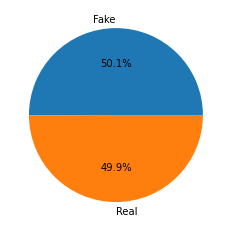

In [24]:
plt.pie(data['label'].value_counts(),labels=['Fake','Real'], autopct='%1.1f%%')
plt.show()

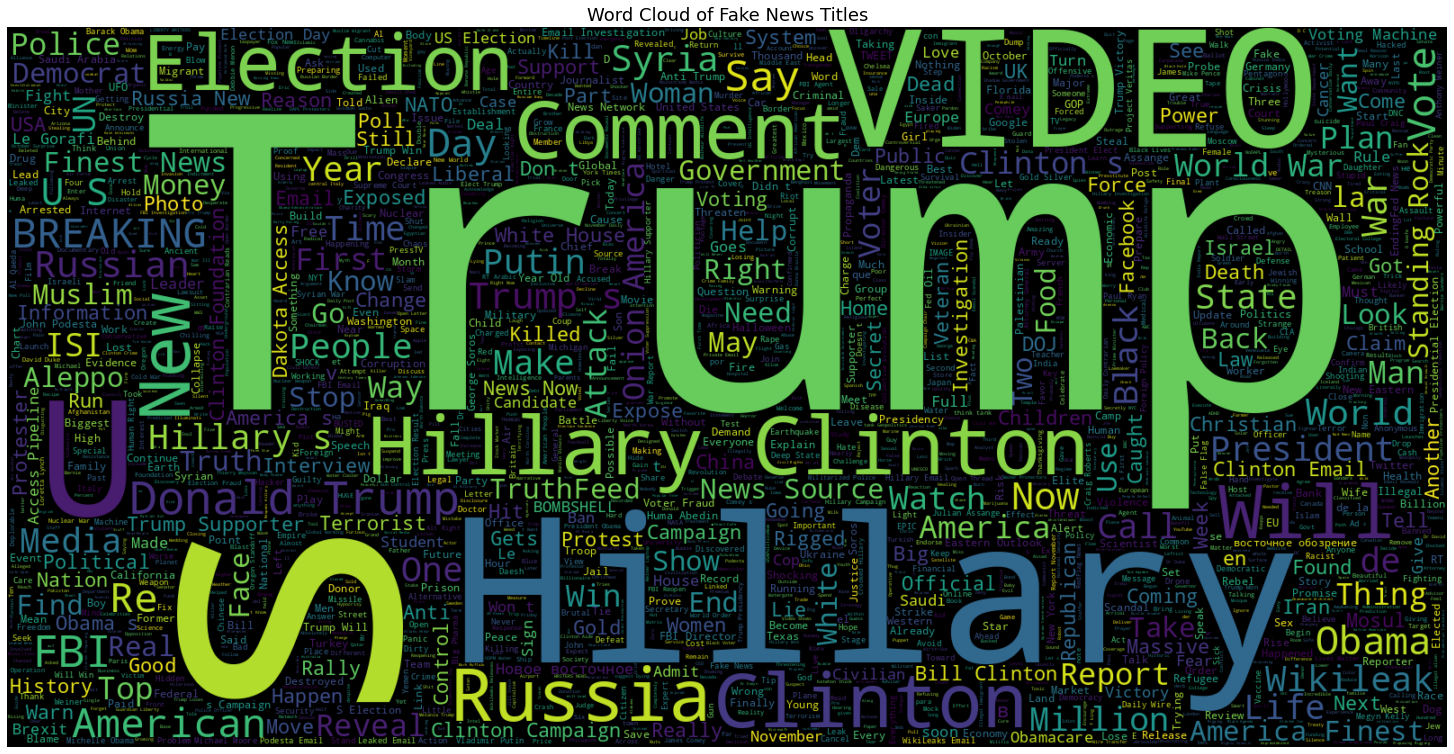

In [25]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.label == 1].title))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud of Fake News Titles', size=18);

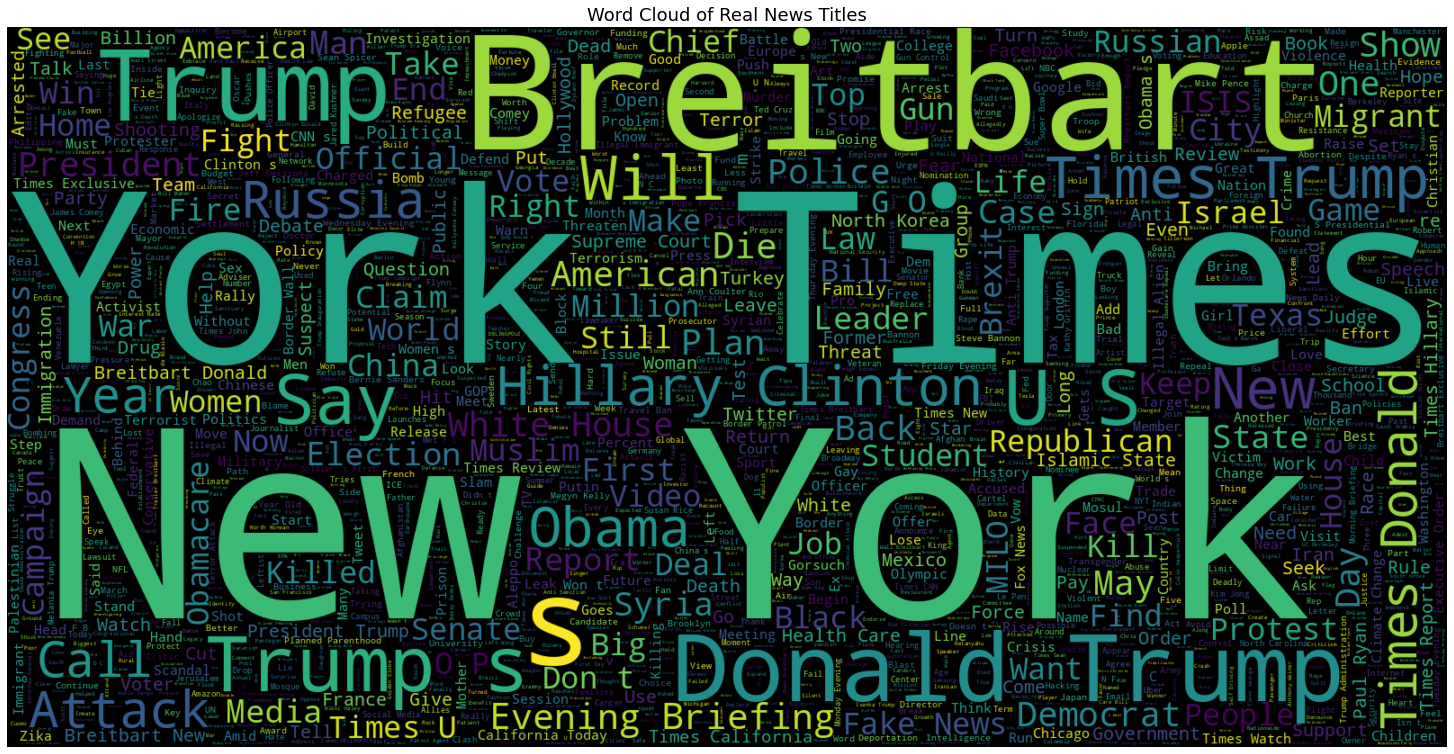

In [26]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.label == 0].title))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.title('Word Cloud of Real News Titles', size=18);

Observation: We can see Fake and Real News share  frequently used words such as "trump", "donald", "clinton", "hilary" ... That is why we can't decide with absolute certainty whether the news is fake or not. However there are some words which can characterize the content of the certain news article and it's credibility.

In [27]:
fig = px.histogram(x = [(len(x) - x.count(' ')) for x in data[data.label == 1].title],labels={'x':'Word Length', 'y':'count'})
fig.update_layout(title="Average Number of Characters in Fake News Titles")
fig.show()

In [28]:
fig = px.histogram(x = [(len(x) - x.count(' ')) for x in data[data.label == 0].title],labels={'x':'Word Length', 'y':'count'})
fig.update_layout(title="Average Number of Characters in Real News Titles")
fig.show()

Observation: On average, the maximum number of characters in titles of valid news range between 50-80 characters whereas the maximum number of characters in titles of fake news range between 30-90 characters. We a still can't judge if the news are true or fake only by the number of characters in their titles.

In [29]:
fig = px.histogram(x = [len(x.split(" ")) for x in data[data.label == 1].title],labels={'x':'Word Count in title', 'y':'count'})
fig.update_layout(title="Average Number of Words in Fake News Titles")
fig.show()

In [30]:
fig = px.histogram(x = [len(x.split(" ")) for x in data[data.label == 0].title],labels={'x':'Word Count in title', 'y':'count'})
fig.update_layout(title="Average Number of Words in Real News Titles")
fig.show()

Observation: On average, the maximum number of words in titles of Real news range between 10-17 words whereas the maximum number of words in titles of fake news range between 5-16 words. We a still can't judge if the news are true or fake only by the number of words in their titles.

In [31]:
fig = px.histogram(x = [len(x.split(" ")) for x in data[data.label == 1].text],labels={'x':'Word Count in text', 'y':'count'})
fig.update_layout(title="Average Number of Words in Fake News text")
fig.show()

In [32]:
fig = px.histogram(x = [len(x.split(" ")) for x in data[data.label == 0].text],labels={'x':'Word Count in text', 'y':'count'})
fig.update_layout(title="Average Number of Words in Real News text")
fig.show()

Observation: On average, the maximum number of words in text of both Real and fake news range between 0-2k words. We a still can't judge if the news are true or fake only by the number of words in their text.

In [33]:
# Get the real news title words
real_title_words = [x.split(' ') for x in data[data.label == 0].stem_title]
# Flatten the list
real_title_words = [item for sublist in real_title_words for item in sublist]

# Get the bigrams
bigram_all = (pd.Series(ngrams(real_title_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Real News Titles: ")
bigram_all

Top 10 most common bigrams in Real News Titles: 


,0
"(new, york)",6344
"(york, time)",6248
"(donald, trump)",621
"(time, trump)",268
"(brief, new)",203
"(hillari, clinton)",194
"(time, donald)",176
"(even, brief)",148
"(say, new)",131
"(white, hous)",126


In [34]:
# Get the fake news title words
fake_title_words = [x.split(' ') for x in data[data.label == 1].stem_title]
# Flatten the list
fake_title_words = [item for sublist in fake_title_words for item in sublist]

# Get the bigrams
bigram_all = (pd.Series(ngrams(fake_title_words, 2)).value_counts())[:10]
bigram_all=pd.DataFrame(bigram_all)

print("Top 10 most common bigrams in Fake News Titles: ")
bigram_all

Top 10 most common bigrams in Fake News Titles: 


,0
"(hillari, clinton)",339
"(donald, trump)",247
"(world, war)",97
"(onion, america)",79
"(america, finest)",79
"(finest, news)",79
"(news, sourc)",79
"(stand, rock)",76
"(clinton, campaign)",73
"(trump, support)",63


#Modeling

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify=Y, random_state=2)

In [36]:
model = LogisticRegression()
model.fit(X_train, Y_train)

#Accuracy score on the training data
Y_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train_prediction, Y_train)
accuracy_value = roc_auc_score(Y_train_prediction, Y_train)
print("Accuracy of the training data -> " + str(round(accuracy_value*100,2)) + "%")
print("f1 score of the training data -> " + str(f1_score(Y_train_prediction, Y_train)))

#Accuracy score on the test data
Y_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test_prediction, Y_test)
accuracy_value = roc_auc_score(Y_test, Y_test_prediction)
print("Accuracy of the test data -> " + str(round(accuracy_value*100,2)) + "%")
print("f1 score of the test data -> " + str(f1_score(Y_test, Y_test_prediction)))

Accuracy of the training data -> 97.29%
f1 score of the training data -> 0.9726075711262638
Accuracy of the test data -> 95.48%
f1 score of the test data -> 0.9563602599814298


In [32]:
#Define parameter grid for grid search
param_grid = {'penalty': ['l1', 'l2','elasticnet','none'],
              'C': [10, 20, 30, 0.1],
              'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']}

#Define logistic regression model
logreg = LogisticRegression(max_iter=500)

#Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

#Print best parameters and accuracy score
print("Best parameters: ", grid_search.best_params_)
print("Best accuracy score: ", grid_search.best_score_)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated 

Best parameters:  {'C': 30, 'penalty': 'l1', 'solver': 'saga'}
Best accuracy score:  0.9771033653846155


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [45]:
model = LogisticRegression(C=35,penalty='l2',solver='saga',max_iter=1000)
model.fit(X_train, Y_train)

#Accuracy score on the training data
Y_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train_prediction, Y_train)
accuracy_value = roc_auc_score(Y_train_prediction, Y_train)
print("Accuracy of the training data -> " + str(round(accuracy_value*100,2)) + "%")
print("f1 score of the training data -> " + str(f1_score(Y_train_prediction, Y_train)))

#Accuracy score on the test data
Y_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test_prediction, Y_test)
accuracy_value = roc_auc_score(Y_test, Y_test_prediction)
print("Accuracy of the test data -> " + str(round(accuracy_value*100,2)) + "%")
print("f1 score of the test data -> " + str(f1_score(Y_test, Y_test_prediction)))

Accuracy of the training data -> 99.99%
f1 score of the training data -> 0.9998799375675351
Accuracy of the test data -> 97.07%
f1 score of the test data -> 0.9710213776722091


# Creating a Predictive System

In [46]:
i =int(input('Enter the index of the news to predict: '))
X_new = X_test[i]

prediction = model.predict(X_new)

if (prediction[0]==0):
  print('"',data['title'][i],'"',': REAL News')
else:
  print('"',data['title'][i],'"',': FAKE News')

Enter the index of the news to predict: 5
" Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart " : FAKE News
